In [65]:
import os
import cv2
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm

from data_loader import get_dicom_paths, parse_metadata, create_labels, load_dataset

# Define paths
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"
LABEL_CSV = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv"

# Function to convert DICOM to JPG and save it
def save_image_from_dicom(dicom_dir, output_img_dir, patient_id):
    img_path = os.path.join(output_img_dir, f"{patient_id}.jpg")
    if os.path.exists(img_path):
        return  # Skip if image already exists

    dicom_path = os.path.join(dicom_dir, f"{patient_id}.dcm")
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array

    # Convert to 3-channel image for YOLO compatibility
    img_rgb = np.stack([img_array] * 3, axis=-1)
    cv2.imwrite(img_path, img_rgb)

# Function to save YOLO-format label file
def save_yolo_label(label_dir, patient_id, row=None):
    img_size = 1024  # RSNA images are 1024x1024
    label_path = os.path.join(label_dir, f"{patient_id}.txt")

    with open(label_path, "a") as f:
        if row is None:
            return  # No bounding box to write

        # Extract bounding box coordinates
        x, y, w, h = row[1], row[2], row[3], row[4]

        # Convert to YOLO format: class_id cx cy width height (all normalized)
        cx = (x + w / 2) / img_size
        cy = (y + h / 2) / img_size
        nw = w / img_size
        nh = h / img_size

        f.write(f"0 {cx} {cy} {nw} {nh}\n")  # Class 0 = pneumonia

# Function to process the entire dataset and save images and labels
def prepare_yolo_dataset(dicom_dir, output_img_dir, label_dir, annotations_df):
    for row in tqdm(annotations_df.values):
        patient_id = row[0]
        target = row[5]  # 1 = pneumonia, 0 = normal

        img_path = os.path.join(output_img_dir, f"{patient_id}.jpg")

        # Skip non-pneumonia cases to save space (optional)
        if target == 0:
            continue

        # Save label and image
        save_yolo_label(label_dir, patient_id, row)
        if not os.path.exists(img_path):
            save_image_from_dicom(dicom_dir, output_img_dir, patient_id)


labels_df = pd.read_csv(LABEL_CSV)
prepare_yolo_dataset(TRAIN_IMG_DIR, "yolo_images", "yolo_labels", labels_df)


100%|██████████| 30227/30227 [00:05<00:00, 5632.48it/s] 


In [66]:
labels_df

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [67]:

# Define paths
LABEL_CSV = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv"
YOLO_IMG_DIR = "yolo_images"
YOLO_LABEL_DIR = "yolo_labels"
IMG_SIZE = 1024 # RSNA image size
labels_df = pd.read_csv(LABEL_CSV)


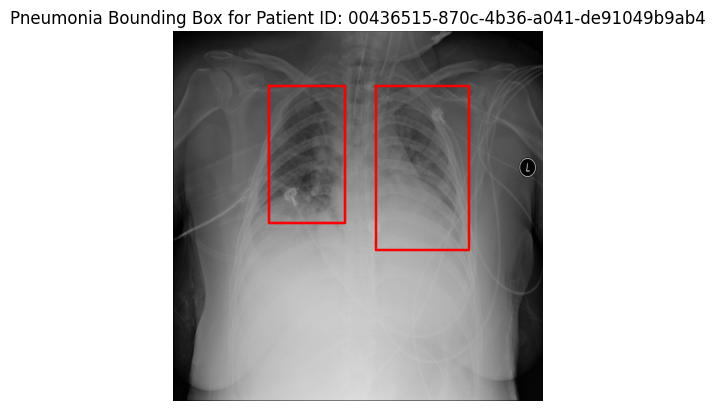

In [68]:

# Get a sample patient ID with pneumonia
ex_patient_id = labels_df[labels_df.Target == 1].patientId.values[0]

# Construct image and label paths
ex_img_path = os.path.join(YOLO_IMG_DIR, f"{ex_patient_id}.jpg")
ex_label_path = os.path.join(YOLO_LABEL_DIR, f"{ex_patient_id}.txt")

# Load and display the image
img = cv2.imread(ex_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)


# Draw bounding boxes from YOLO label
with open(ex_label_path, "r") as f:
     for line in f:
        class_id, rcx, rcy, rw, rh = map(float, line.strip().split())
        x = (rcx - rw / 2) * IMG_SIZE
        y = (rcy - rh / 2) * IMG_SIZE
        w = rw * IMG_SIZE
        h = rh * IMG_SIZE
        plt.plot([x, x + w, x + w, x, x], [y, y, y + h, y + h, y],color='red')

plt.title(f"Pneumonia Bounding Box for Patient ID: {ex_patient_id}")
plt.axis('off')
plt.show()



In [69]:
def write_image_list_file(output_dir, image_dir, filename, patient_ids):
    """
    Writes a list of image file paths (one per line) to a text file.

    Parameters:
    - output_dir (str): Directory where the list file will be saved.
    - image_dir (str): Directory containing the image files.
    - filename (str): Name of the output text file (e.g., 'train.txt').
    - patient_ids (iterable): List or Series of patient IDs to include.
    """
    list_path = os.path.join(output_dir, filename)

    with open(list_path, "w") as f:
        for patient_id in patient_ids:
            image_path = os.path.join(image_dir, f"{patient_id}.jpg")
            f.write(f"{image_path}\n")


In [70]:
from sklearn.model_selection import train_test_split

def split_and_write_image_lists(annotations_df, image_dir, output_dir, test_size=0.1, random_state=42):
    """
    Splits pneumonia-positive patient IDs into training and validation sets,
    and writes their image paths to text files.

    Parameters:
    - annotations_df (DataFrame): The full annotations DataFrame.
    - image_dir (str): Directory containing the YOLO-format images.
    - output_dir (str): Directory to save the train/val list files.
    - test_size (float): Proportion of validation set.
    - random_state (int): Seed for reproducibility.
    """
    # Filter for pneumonia-positive cases and drop duplicates
    positive_ids = annotations_df[annotations_df.Target == 1].patientId.drop_duplicates()

    # Split into train and validation sets
    train_ids, val_ids = train_test_split(positive_ids, test_size=test_size, random_state=random_state)

    print(f"The # of train set: {len(train_ids)}, The # of validation set: {len(val_ids)}")

    # Write image path lists
    write_image_list_file(output_dir, image_dir, "tr_list.txt", train_ids)
    write_image_list_file(output_dir, image_dir, "val_list.txt", val_ids)


In [71]:
split_and_write_image_lists(
    annotations_df=labels_df,
    image_dir="yolo_images",
    output_dir="metadata",
    test_size=0.15,
    random_state=42
)


The # of train set: 5110, The # of validation set: 902


In [72]:
import os

def save_yolo_test_data(test_dicom_dir, output_img_dir, output_list_dir, list_filename, patient_ids):
    """
    Converts test DICOM images to JPG and writes their paths to a list file.

    Parameters:
    - test_dicom_dir (str): Directory containing test DICOM files.
    - output_img_dir (str): Directory to save converted JPG images.
    - output_list_dir (str): Directory to save the list file.
    - list_filename (str): Name of the list file (e.g., 'te_list.txt').
    - patient_ids (iterable): List or Series of patient IDs to process.
    """
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_list_dir, exist_ok=True)

    list_path = os.path.join(output_list_dir, list_filename)

    with open(list_path, "w") as f:
        for patient_id in patient_ids:
            save_image_from_dicom(test_dicom_dir, output_img_dir, patient_id)
            image_path = os.path.join(output_img_dir, f"{patient_id}.jpg")
            f.write(f"{image_path}\n")


In [73]:
import glob
import pandas as pd

# Define paths
test_dcm_dir = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"
img_dir = "yolo_test_images"
metadata_dir = "metadata"

# Get list of test DICOM patient IDs
test_dcm_fps = glob.glob(os.path.join(test_dcm_dir, '*.dcm'))
test_patient_ids = pd.Series(test_dcm_fps).apply(lambda fp: os.path.basename(fp).replace(".dcm", ""))

# Save test data
save_yolo_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_patient_ids)


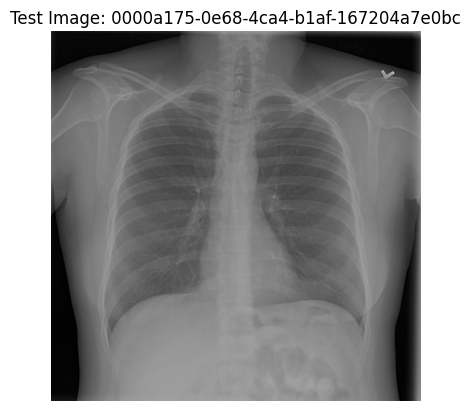

In [74]:
if not test_patient_ids.empty:
    ex_patient_id = test_patient_ids.iloc[0]
    ex_img_path = os.path.join(img_dir, f"{ex_patient_id}.jpg")
    img = cv2.imread(ex_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Test Image: {ex_patient_id}")
    plt.axis('off')
    plt.show()
else:
    print("No test DICOM files found.")


In [75]:
x_center_pixel = x * image_width
y_center_pixel = y_center * image_height
width_pixel = width * image_width
height_pixel = height * image_height


NameError: name 'image_width' is not defined

In [ ]:
import os
import cv2
import numpy as np
def convert_yolo_to_mask(images_dir, labels_dir, masks_dir):
    os.makedirs(masks_dir, exist_ok=True)

    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue

        image_name = os.path.splitext(label_file)[0] + '.jpg'
        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(labels_dir, label_file)

        if not os.path.exists(image_path):
            print(f"Image {image_name} not found for label {label_file}")
            continue

        image = cv2.imread(image_path)
        height, width = image.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                _, x_center, y_center, w, h = map(float, parts)
                x_center *= width
                y_center *= height
                w *= width
                h *= height

                x1 = int(x_center - w / 2)
                y1 = int(y_center - h / 2)
                x2 = int(x_center + w / 2)
                y2 = int(y_center + h / 2)

                cv2.rectangle(mask, (x1, y1), (x2, y2), color=255, thickness=-1)

        mask_path = os.path.join(masks_dir, os.path.splitext(label_file)[0] + '.png')
        cv2.imwrite(mask_path, mask)

    print("Conversion completed. Masks saved to:", masks_dir)

# Example usage:
convert_yolo_to_mask('images', 'labels', 'masks')


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'labels'